=== Logistic Regression ===
ROC AUC: 0.844850299538747
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1552
           1       0.67      0.56      0.61       561

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113


Top features (Logistic Regression):
                                    coef  odds_ratio
InternetService_Fiber optic     0.699840    2.013430
TotalCharges                    0.630089    1.877778
PaperlessBilling                0.405525    1.500090
PaymentMethod_Electronic check  0.369438    1.446922
MultipleLines_Yes               0.283926    1.328335
StreamingMovies_Yes             0.261372    1.298711
StreamingTV_Yes                 0.169134    1.184279
SeniorCitizen                   0.142598    1.153266
PaymentMethod_Mailed check      0.080424    1.083746
gender_Male                     0.022834    1.02309

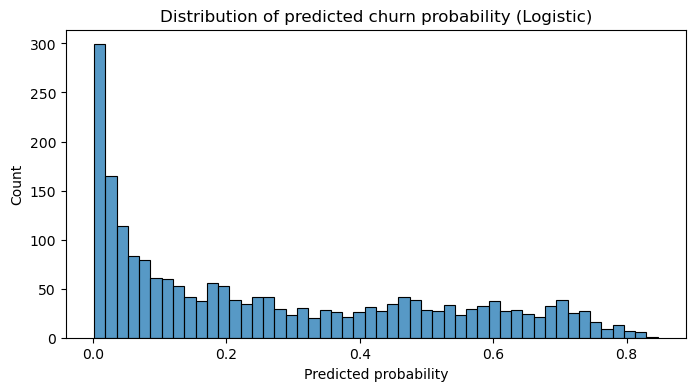

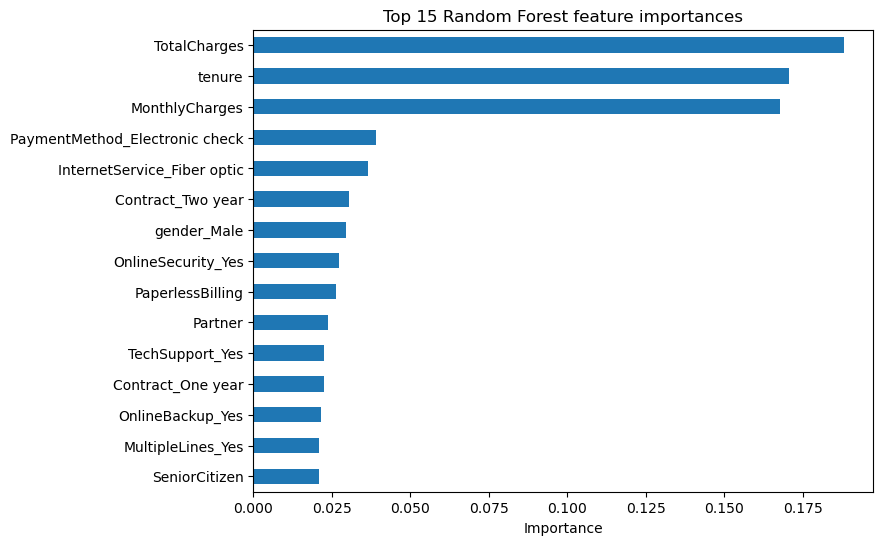

In [4]:
# modeling.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# 1. Load data
df = pd.read_csv("Telco-Customer-Churn-Cleaned.csv")

# 2. Tiền xử lý
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])

# Map Yes/No -> 1/0
for col in df.columns:
    if df[col].dtype == object:
        vals = set(df[col].dropna().unique())
        if vals.issuperset({'Yes','No'}):
            df[col] = df[col].map({'Yes':1,'No':0})

# Target
# Chuẩn hóa cột Churn
if df['Churn'].dtype == object:
    # nếu là Yes/No
    df['Churn'] = df['Churn'].str.strip().str.title()  # "yes"/"no" -> "Yes"/"No"
    df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
else:
    # nếu đã là numeric (0/1)
    df['Churn'] = df['Churn'].astype(int)



# Drop customerID nếu có
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# 3. X/y + One-hot encode
X = df.drop(columns=['Churn'])
y = df['Churn']
X = pd.get_dummies(X, drop_first=True)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 5. Scale numeric
num_cols = ['tenure','MonthlyCharges','TotalCharges']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 6. Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train, y_train)

y_prob_lr = logreg.predict_proba(X_test)[:,1]
y_pred_lr = logreg.predict(X_test)

print("=== Logistic Regression ===")
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))

# Coefficients
coef = pd.Series(logreg.coef_[0], index=X_train.columns)
odds = np.exp(coef)
coef_df = pd.DataFrame({'coef': coef, 'odds_ratio': odds})
print("\nTop features (Logistic Regression):")
print(coef_df.sort_values('odds_ratio', ascending=False).head(10))

# 7. Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest ===")
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print("\nTop features (Random Forest):")
print(importances.sort_values(ascending=False).head(10))

# 8. Visualization
# Histogram Logistic
plt.figure(figsize=(8,4))
sns.histplot(y_prob_lr, bins=50, kde=False)
plt.title("Distribution of predicted churn probability (Logistic)")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.savefig("hist_predicted_churn.png", dpi=300, bbox_inches="tight")
plt.show()

# Feature Importances RF
plt.figure(figsize=(8,6))
importances.sort_values(ascending=False).head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Random Forest feature importances")
plt.xlabel("Importance")
plt.savefig("rf_feature_importances.png", dpi=300, bbox_inches="tight")
plt.show()

